## Import Modules

In [59]:
import pandas as pd
import numpy as np

from  cbcdb import DBManager
import datetime
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

## Read in Data

In [60]:
load_dotenv(find_dotenv())
db = DBManager()

In [100]:
sql = """
 select
    f.animal_id
    , f.species
    , f.ani_age
    , f.datetime
    , f.weight
    , f.name
    , f.type
    , f.tracking_level
    , f.product_group
    , f.visit_more_than_once
    , f.rev_day_total
    , f.rank_
    , sum(f.revenue)                                                as revenue
    from (select
            t.animal_id
             , a.species
             , max(date_diff('years', timestamp 'epoch' + a.date_of_birth * interval '1 second', current_date)) as ani_age
             , trunc(t.datetime_date)                                                                           as datetime
             , a.weight
             , p.name
             , p.type
             , p.tracking_level
             , p.product_group
             , case
                   when a.id in (select
                                    distinct x.animal_id
                                    from (
                                        select t.animal_id
                                                , trunc(t.datetime_date)  as date
                                                , sum(t.revenue)          as revenues
                                                , dense_rank()  over (partition by animal_id order by trunc(t.datetime_date) asc)              as rank_
                                           from bi.transactions t
                                                    left join bi.divisions d
                                                              on d.division_id = t.division_id
                                                    inner join bi.animals a
                                                               on a.id = t.animal_id
                                                                and a.location_id = t.location_id
                                                    inner join bi.products p
                                                               on t.product_id = p.ezyvet_id
                                                                   and t.location_id = p.location_id
                                                                   and p.is_medical = 1
                                           where is_dead = 0
                                             and a.active = 1
                                             and p.product_group != 'Surgical Services'
                                           group by 1, 2
                                           having  revenues > 100) x
                                    where x.rank_ > 1)
                    then 1 else 0 end                                                                       as visit_more_than_once
                , t.revenue                                                                                 as revenue
                , dense_rank() over (partition by t.animal_id order by datetime asc)                        as rank_
                , sum(t.revenue) over (partition by t.animal_id, trunc(t.datetime_date) )                   as rev_day_total

            from bi.transactions t
                     inner join bi.products p
                                on t.product_id = p.ezyvet_id
                                    and t.location_id = p.location_id
                                    and p.is_medical = 1
                     inner join bi.animals a
                                on a.id = t.animal_id
                     left join bi.contacts c
                               on a.contact_id = c.ezyvet_id
                                   and t.location_id = c.location_id
            where p.name not like '%Subscri%'
              and p.product_group != 'Surgical Services'
            group by 1, 2, 4, 5, 6, 7, 8, 9, 10, 11) f
--where f.rev_day_total > 100
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12; """
df = db.get_sql_dataframe(sql)
df_ = df.copy()

2021-05-19 17:10:07,238| ERROR   | Password is required for key /Users/adhamsuliman/.ssh/id_rsa
2021-05-19 17:10:07,238 - ERROR    - Password is required for key /Users/adhamsuliman/.ssh/id_rsa
2021-05-19 17:10:07,384 - INFO     - Connected (version 2.0, client OpenSSH_7.4)
2021-05-19 17:10:07,941 - INFO     - Authentication (publickey) successful!


## Exploratoy Data Analysis
#### Amount of time between first and second appointment


In [101]:
df_valid = df[df.datetime<datetime.date(datetime.date.today().year-1 , datetime.date.today().month+6, datetime.date.today().day)]
#df_valid = df[df.datetime<datetime.date(datetime.date.today().year-1 , datetime.date.today().month, datetime.date.today().day)]
df = df.merge(df_valid['animal_id']).copy()

len(df.animal_id.unique())

790

In [102]:
df1 = df[['animal_id','visit_more_than_once']].drop_duplicates().copy()

In [103]:
df1.visit_more_than_once.value_counts()

0    743
1     47
Name: visit_more_than_once, dtype: int64

In [104]:
44/(44+511)

0.07927927927927927

In [105]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.columns

Index(['animal_id', 'species', 'ani_age', 'datetime', 'weight', 'name', 'type',
       'tracking_level', 'product_group', 'visit_more_than_once',
       'rev_day_total', 'rank_', 'revenue'],
      dtype='object')

(array([737485., 737516., 737546., 737577., 737607., 737638., 737669.,
        737699., 737730., 737760.]),
 <a list of 10 Text major ticklabel objects>)

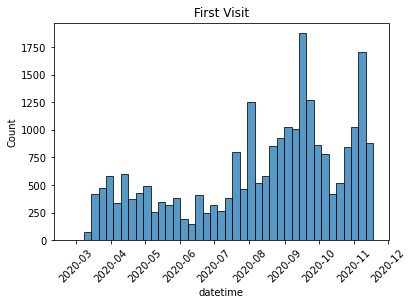

In [106]:
sns.histplot(data=df[df.rank_==1],x='datetime').set(title='First Visit')
plt.xticks(rotation=45)

([<matplotlib.axis.XTick at 0x7fb8a1f78070>,
 <a list of 10 Text major ticklabel objects>)

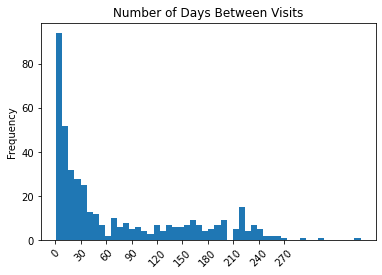

In [139]:
df_visit_1 = df[df.rank_ == 1]
df_visit_2 = df[df.rank_ == 2]
df_diff = df_visit_1[['animal_id','datetime']].merge(df_visit_2[['animal_id','datetime']], on='animal_id').drop_duplicates()
df_diff['date'] = df_diff.apply(lambda x: x.datetime_y -x.datetime_x, axis = 1 )
df_diff['date'].astype('timedelta64[D]').plot.hist(bins = 50).set(title='Number of Days Between Visits')
plt.xticks(np.arange(0, 300, 30), rotation=45)
#plt.yticks(np.arange(0,16,1))

In [108]:
df_diff.date.value_counts().sort_index()

1 days      23
2 days      11
3 days      16
4 days      11
5 days       3
            ..
264 days     1
271 days     1
294 days     1
313 days     1
360 days     1
Name: date, Length: 166, dtype: int64

### Combine similar product types

In [109]:
print(df.name.unique(),len(df.name.unique()))

['Simparica Trio 44.1-88 lbs - per dose' 'DHLPP (1 year both)'
 'Canine Rabies (1 year)' 'Bordetella (Intranasal)'
 'Vetscan Rapid Heartworm Test' 'Examination'
 'Euthanasia Solution Injectable per mL'
 'Tilozan Injectable 100mg/ml (generic Telazol)'
 'Credelio (25-50lbs) - per dose' 'Trazodone, 100mg Tablets'
 'Leptospirosis (1 year)' 'Interceptor Plus (25-50 lbs) - per dose'
 'Canine Rabies (3 year)' 'Antech Ova and Parasite with Giardia'
 'Nail trim (Routine)' 'Simparica Trio 11.1-22 lbs - per dose'
 'Antech Ova and Parasite' 'DHPP (Booster)' 'Puppy/Kitten Booster Exam'
 'Anal Sac Expression' 'DHLPP (Booster, 1 year Lepto)'
 'Simparica Trio 5.6-11 lbs - per dose' 'Dental cleaning recommended'
 'External Prescription' 'Cytology In house (Mass/Fluid)'
 'Animax/Dermalone/EnteDerm/Dermavet Ointment, 15 mL'
 'Examination - Free Employee Pet' 'Apoquel, 16 mg Tablets'
 'DL-Methionine 500mg' 'DHLPP (3 year, 1 year Lepto)'
 'Microchip implantation and registration'
 'Cerenia 60 mg Tablets Bo

In [110]:
df['name'] = df['name'].apply(lambda x: ' '.join(x.split(' ')[0:2]))
print(len(df.name.unique()))

383


## Create new DataFrame aggregated on new product name column

In [111]:
df = df.groupby(['animal_id', 'species', 'datetime', 'name', #'ani_age','weight', 
       'type', 'tracking_level', 'product_group', 'visit_more_than_once', 'rank_'], as_index = False)['revenue'].sum()

#### Identify number of visits

1     359
2     137
3     101
4      64
5      44
6      33
7      18
8       8
9       9
10      6
11      4
12      3
14      1
17      1
18      1
22      1
Name: rank_, dtype: int64


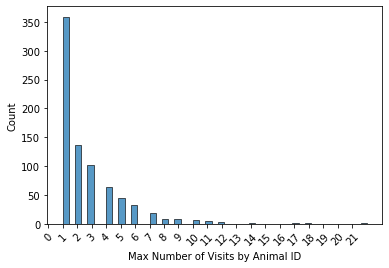

In [112]:
df_visit = df.groupby(['animal_id'], as_index = False)['rank_'].max()
print(df_visit['rank_'].value_counts().sort_index())
sns.histplot(df_visit, x='rank_')
plt.xticks(np.arange(0,22,1), rotation = 45)
plt.xlabel('Max Number of Visits by Animal ID')
plt.show()

#### New df to identify max number of visits and if customer returns

## Are dog owners or pet owners more likely to return?

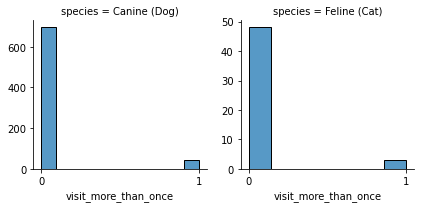

In [113]:
df_animal_tot_rev = df.groupby(['animal_id','species','visit_more_than_once'], as_index = False)['revenue'].sum().copy()
g = sns.FacetGrid(df_animal_tot_rev,
                    col="species",
                    sharex = False,
                    sharey = False)
g.map(sns.histplot, "visit_more_than_once")
g.set(xticks=(np.arange(0, 2, 1)))

## Is age of pet associated with return?

df_animal_tot_rev = df.groupby(['animal_id','species','ani_age','visit_more_than_once'], as_index = False)['revenue'].sum().copy()
g = sns.FacetGrid(df_animal_tot_rev,
                    col="ani_age",
                    sharex = False,
                    sharey = False,
                    col_wrap = 5)
g.map(sns.histplot, "visit_more_than_once")
g.set(xticks=(np.arange(0, 2, 1)))

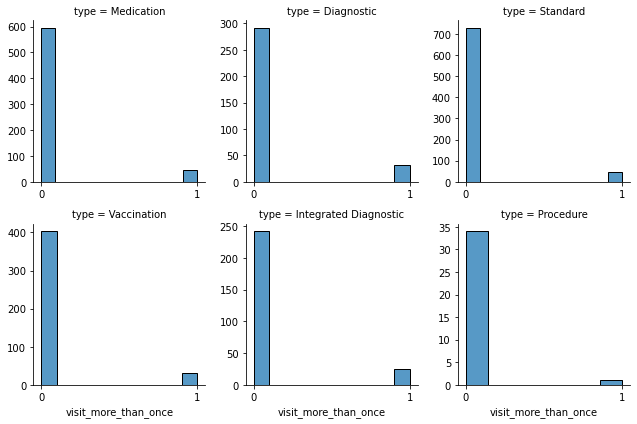

In [114]:
df_animal_tot_rev = df.groupby(['animal_id','species','type','visit_more_than_once'], as_index = False)['revenue'].sum().copy()
g = sns.FacetGrid(df_animal_tot_rev,
                    col="type",
                    sharex = False,
                    sharey = False,
                    col_wrap = 3)
g.map(sns.histplot, "visit_more_than_once")
g.set(xticks=(np.arange(0, 2, 1)))

In [115]:
21/(21+44)

0.3230769230769231

2021-05-19 17:10:23,002 - WARNING  - /opt/anaconda3/envs/cbc/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.



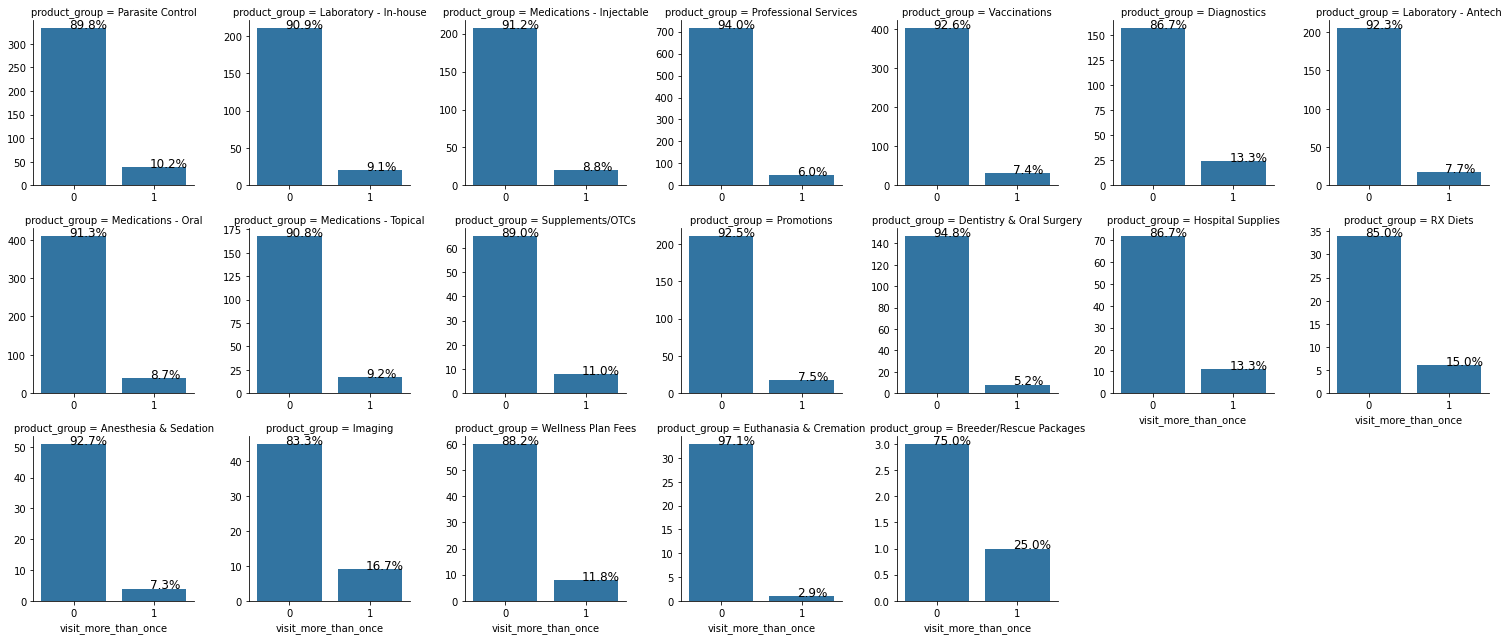

In [118]:
df_animal_tot_rev = df.groupby(['animal_id','species','product_group','visit_more_than_once'], as_index = False)['revenue'].sum().copy()
g = sns.FacetGrid(df_animal_tot_rev,
                    col="product_group",
                    sharex = False,
                    sharey = False,
                    col_wrap = 7)
g.map(sns.countplot, "visit_more_than_once")
for ax in g.axes.ravel():
    total = sum([x.get_height() for x in ax.patches])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

plt.show()

#### Identify most common types of visits

In [119]:
from plotnine import *
from plotnine.mapping import after_stat


In [120]:
from plotnine.data import mtcars

In [121]:
mtcars

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


2846


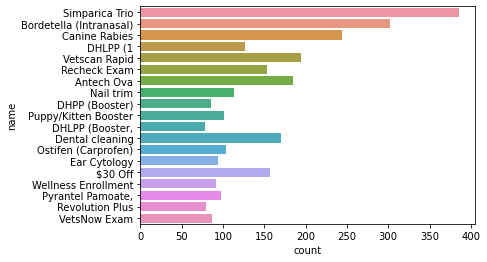

In [122]:
df_ = df[df['name']!='Examination']
df1 = df_[df_.groupby("name")['name'].transform('size') > 75].reset_index(drop = True)
print(df1.shape[0])
sns.countplot(y='name', data = df1)
#for tick in ax.xaxis.get_major_ticks()[1::2]:
#    tick.set_pad(15)

plt.show()

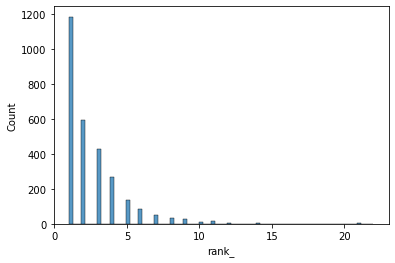

In [123]:
sns.histplot(df1, x='rank_')
plt.show()

In [124]:

print(df[((df.visit_more_than_once == 1) & (df.rank_==1))].product_group.value_counts().sort_index(),)
print(df[((df.visit_more_than_once == 1) & (df.rank_==2))].product_group.value_counts().sort_index())

Dentistry & Oral Surgery     1
Diagnostics                 18
Hospital Supplies            1
Imaging                      1
Laboratory - Antech          8
Laboratory - In-house       10
Medications - Injectable     6
Medications - Oral          40
Medications - Topical       14
Parasite Control            28
Professional Services       59
Promotions                   6
RX Diets                     1
Supplements/OTCs             2
Vaccinations                35
Wellness Plan Fees           5
Name: product_group, dtype: int64
Anesthesia & Sedation       13
Breeder/Rescue Packages      1
Dentistry & Oral Surgery     5
Diagnostics                 12
Euthanasia & Cremation       3
Hospital Supplies            6
Laboratory - Antech          2
Laboratory - In-house        4
Medications - Injectable    24
Medications - Oral          20
Medications - Topical        9
Parasite Control            15
Professional Services       35
Promotions                   3
RX Diets                     1
Suppl

In [125]:
#df_product = pd.get_dummies(df1.name)
df_product_group = pd.get_dummies(df.product_group)
df_species = pd.get_dummies(df.species)
#df_ = pd.concat([df1,df_product,df_species, df_product_group]).fillna(0).drop(columns = ['species','name','product_group'])
df_ = pd.concat([df,df_species, df_product_group], axis =1).drop(columns = ['species','name','product_group']) #, axis = 1
df_

,animal_id,datetime,type,tracking_level,visit_more_than_once,rank_,revenue,Canine (Dog),Feline (Cat),Anesthesia & Sedation,...,Medications - Injectable,Medications - Oral,Medications - Topical,Parasite Control,Professional Services,Promotions,RX Diets,Supplements/OTCs,Vaccinations,Wellness Plan Fees
0,3,2020-04-30,Medication,Product,0,1,26.22,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,6,2020-05-08,Vaccination,No,0,1,96.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,6,2020-05-08,Vaccination,No,0,1,81.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6,2020-05-08,Vaccination,No,0,1,93.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6,2020-05-08,Standard,No,0,1,0.00,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7793,5585,2020-11-17,Medication,Product,0,1,88.68,1,0,0,...,0,0,0,1,0,0,0,0,0,0
7794,5586,2020-11-17,Standard,No,0,1,149.97,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7795,5586,2020-11-17,Standard,No,0,1,405.00,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7796,5586,2020-11-17,Medication,Product,0,1,88.68,1,0,0,...,0,0,0,1,0,0,0,0,0,0


### Split first visit from dataframe and then split into train and test on whether they returned.

In [126]:
df_dog = df_[(df_['Canine (Dog)'] ==1) & (df_['rank_'] <= 5)]
df_final = df_dog.groupby(['animal_id','rank_'], as_index = False)['Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', #'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() #, 'Wellness Plan Fees', 'Dentistry & Oral Surgery', 'To Print Burkett',
df_final.rename(columns = {'rank_':'Number of Visits'}, inplace=True)
print(df_final['Number of Visits'].value_counts())
df_final_ = pd.pivot_table(df_final, 
                            values = ['Diagnostics',
                            'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
                            'Laboratory - Antech', 'Laboratory - In-house',
                            'Medications - Injectable', 'Medications - Oral',
                            'Medications - Topical', 'Parasite Control', #'Professional Services',
                            'Promotions', 'RX Diets',  'Supplements/OTCs',
                            'Vaccinations'], 
                            index = 'Number of Visits')

2021-05-19 17:10:27,208 - WARNING  - <ipython-input-126-9d2777edfb06>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

1    739
2    419
3    287
4    190
5    126
Name: Number of Visits, dtype: int64


In [127]:
df_final.rename(columns = {'rank_':'Number of Visits'}, inplace=True)
df_final['Number of Visits'].value_counts()

1    739
2    419
3    287
4    190
5    126
Name: Number of Visits, dtype: int64

Run once for dogs and once for cats

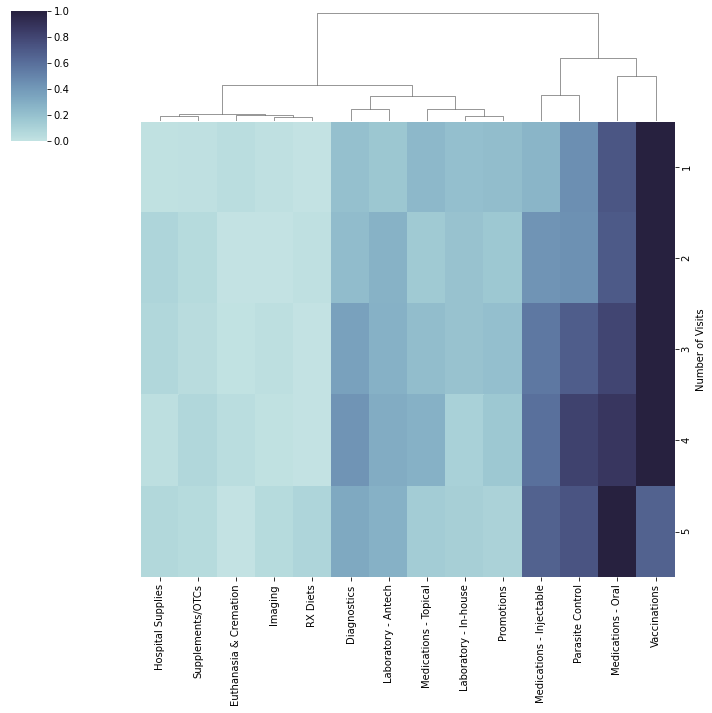

In [128]:
color = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.clustermap(df_final_, 
                standard_scale=0,
                cmap=color,
                robust=True,
                row_cluster=False)
plt.show()

In [129]:
df_cat = df_[(df_['Feline (Cat)'] ==1) & (df_['rank_'] <= 2)]
df_final = df_cat.groupby(['animal_id','rank_'], as_index = False)['Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', #'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() #, 'Wellness Plan Fees', 'Dentistry & Oral Surgery', 'To Print Burkett',
df_final.rename(columns = {'rank_':'Number of Visits'}, inplace=True)
print(df_final['Number of Visits'].value_counts())
df_final_ = pd.pivot_table(df_final, 
                            values = ['Diagnostics',
                            'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
                            'Laboratory - Antech', 'Laboratory - In-house',
                            'Medications - Injectable', 'Medications - Oral',
                            'Medications - Topical', 'Parasite Control', #'Professional Services',
                            'Promotions', 'RX Diets',  'Supplements/OTCs',
                            'Vaccinations'], 
                            index = 'Number of Visits')

2021-05-19 17:10:27,776 - WARNING  - <ipython-input-129-1cf4d27c3e99>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

1    51
2    12
Name: Number of Visits, dtype: int64


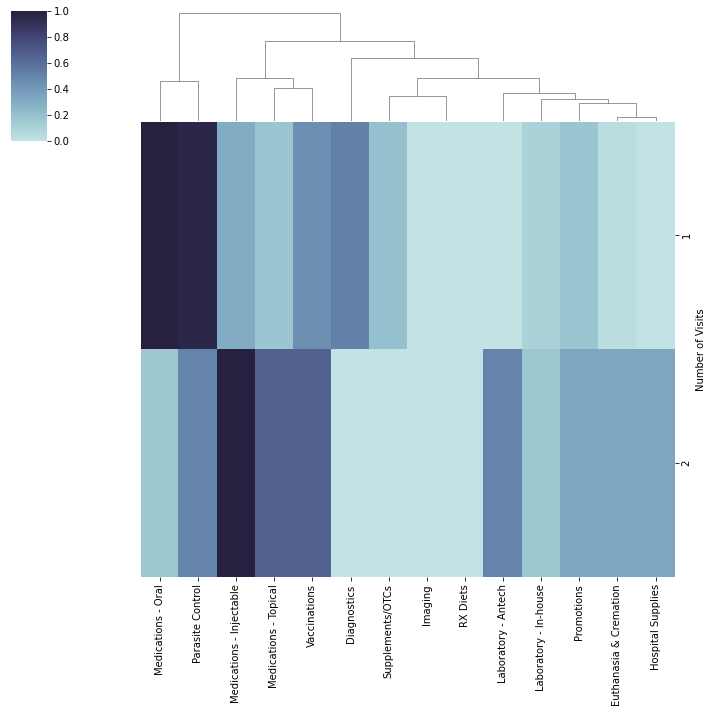

In [130]:
color = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.clustermap(df_final_, 
                standard_scale=0,
                cmap=color,
                robust=True,
                row_cluster=False)
plt.show()

In [131]:
df_final.animal_id.nunique()

51

In [132]:
df_final = df_.groupby(['animal_id','visit_more_than_once','rank_'], as_index = False)['Canine (Dog)',
       'Feline (Cat)', 'Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', 'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() 
        
df_first_visit = df_final[df_final.rank_==1]
X = df_first_visit[['Canine (Dog)',
       'Feline (Cat)', 'Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', 'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations']]
y = df_first_visit['visit_more_than_once'].apply(lambda x: int(x))
#X.columns[X.nunique() == 1]

2021-05-19 17:10:28,244 - WARNING  - <ipython-input-132-99584bbba686>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .2,
                                                    random_state = 42)

In [134]:
# Below will fail with a perfect separation error
res = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
res.params

#res2 = sm.GLM(y_train, Xs, family=sm.families.Binomial()).fit_regularized(L1_wt=0.0, alpha=0.1)
#params = res2.params

Canine (Dog)                -0.266631
Feline (Cat)                -0.357110
Diagnostics                  0.844697
Euthanasia & Cremation     -21.378147
Hospital Supplies            0.585206
Imaging                    -22.294400
Laboratory - Antech          0.316297
Laboratory - In-house        0.165436
Medications - Injectable    -0.387657
Medications - Oral           0.513136
Medications - Topical        0.105969
Parasite Control             0.288455
Professional Services       -1.585389
Promotions                  -1.076425
RX Diets                     0.253708
Supplements/OTCs             0.215833
Vaccinations                -0.037386
dtype: float64

In [135]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     visit_more_than_once   No. Observations:                  632
Model:                              GLM   Df Residuals:                      615
Model Family:                  Binomial   Df Model:                           16
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -168.67
Date:                  Wed, 19 May 2021   Deviance:                       337.34
Time:                          17:10:28   Pearson chi2:                 2.79e+03
No. Iterations:                      23                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Canine (Dog)                -0.2666      0.515     -0.518      0.605      -1.276       0.743
Feline (Cat)                -0.3571      0.555     -0.644      0.520      -1.444       0.730
Diagnostics                  0.8447      0.608      1.389      0.165      -0.347       2.036
Euthanasia & Cremation     -21.3781   1.71e+04     -0.001      0.999   -3.35e+04    3.35e+04
Hospital Supplies            0.5852      1.200      0.488      0.626      -1.767       2.938
Imaging                    -22.2944   2.75e+04     -0.001      0.999    -5.4e+04    5.39e+04
Laboratory - Antech          0.3163      0.730      0.433      0.665      -1.115       1.748
Laboratory - In-house        0.1654      0.644      0.257      0.797      -1.097       1.428
Medications - Injectable    -0.3877      0.671     -0.577      0.564      -1.703       0.928
Medications - Oral           0.5131      0.560      0.917      0.359      -0.584       1.610
Medications - Topical        0.1060      0.598      0.177      0.859      -1.067       1.279
Parasite Control             0.2885      0.558      0.517      0.605      -0.804       1.381
Professional Services       -1.5854      0.590     -2.687      0.007      -2.742      -0.429
Promotions                  -1.0764      0.769     -1.399      0.162      -2.584       0.431
RX Diets                     0.2537      1.241      0.204      0.838      -2.179       2.687
Supplements/OTCs             0.2158      1.021      0.211      0.833      -1.786       2.218
Vaccinations                -0.0374      0.561     -0.067      0.947      -1.136       1.061
============================================================================================
"""

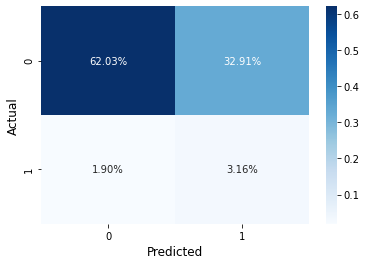

In [136]:
#Generate predictions with the model using our X values
y_pred = res.predict(X_test)
y_pred = y_pred.apply(lambda x: 1 if x > Find_Optimal_Cutoff(y_test, y_pred)[0] else 0)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.xlabel('Predicted', size = 'large')
plt.ylabel('Actual', size = 'large')
plt.show()

In [137]:
model = Sequential()
model.add(Dense(32, input_dim=17, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 10,
            validation_split = .2,
            callbacks = [es])

Epoch 1/100
51/51 [==============================] - 1s 5ms/step - loss: 0.4171 - accuracy: 0.9454 - val_loss: 0.3055 - val_accuracy: 0.9370
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3033 - accuracy: 0.9260 - val_loss: 0.2884 - val_accuracy: 0.9370
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9462 - val_loss: 0.2720 - val_accuracy: 0.9370
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3044 - accuracy: 0.9191 - val_loss: 0.2703 - val_accuracy: 0.9370
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2596 - accuracy: 0.9331 - val_loss: 0.2521 - val_accuracy: 0.9370
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2303 - accuracy: 0.9376 - val_loss: 0.2495 - val_accuracy: 0.9370
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2194 - accuracy: 0.9398 - val_loss: 0.2445 - val_accuracy: 0.9370
Epoch 8/100
5

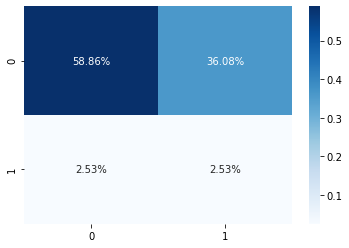

In [138]:
#Generate predictions with the model using our X values
y_pred = model.predict(X_test)
y_pred = y_pred.ravel().tolist()
y_pred_ = [1 if y > Find_Optimal_Cutoff(y_test, y_pred)[0] else 0 for y in y_pred ]

cf_matrix = confusion_matrix(y_test, y_pred_)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')